In [1]:
import os
import numpy as np
import pandas as pd
from Bio.PDB.Polypeptide import three_to_index
from Bio.PDB.Polypeptide import one_to_three

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'

In [3]:
def getPCA(matrix):
    eVal, eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal, eVec

def mpPDF(var, q, pts):
    eMin,eMax=var*(1-(1./q)**.5)**2, var*(1+(1./q)**0.5)**2
    eVal=np.linspace(eMin, eMax, pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf, index=eVal)
    return pdf

from sklearn.neighbors.kde import KernelDensity
def fitKDE(obs, bWidth=.25, kernel="gaussian", x=None):
    if len(obs.shape)==1: obs=obs.reshape(-1, 1)
    kde=KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None: x=np.unique(obs).reshape(-1, 1)
    if len(x.shape)==1: x=x.reshape(-1, 1)
    logProb=kde.score_samples(x)
    pdf=pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

/Users/weilu/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
x = np.random.normal(size=(10000, 1000))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))

In [5]:
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)

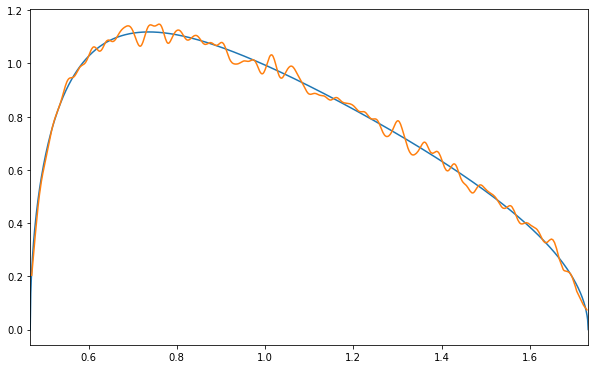

In [6]:
pdf0.plot()
pdf1.plot()

In [8]:
x = np.random.normal(size=(10000, 1000), scale=5, loc=2)
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))

pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)

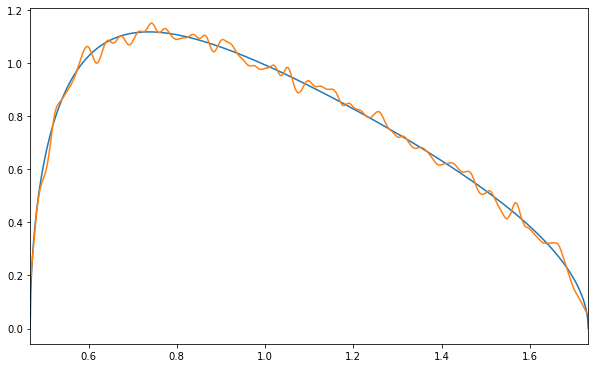

In [9]:
pdf0.plot()
pdf1.plot()

In [10]:
x = np.random.normal(size=(2000, 200), scale=5)
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))

pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)

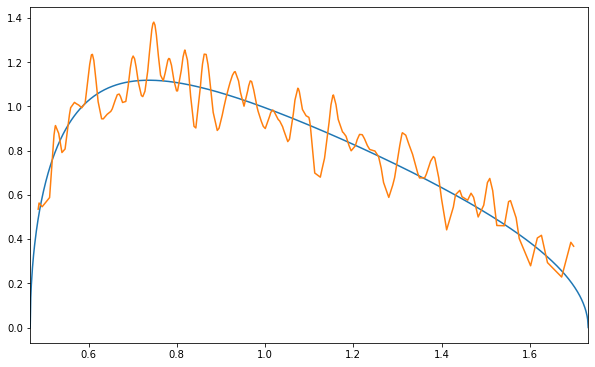

In [11]:
pdf0.plot()
pdf1.plot()

In [12]:
cov = np.cov(x, rowvar=0)

In [13]:
i = 0
j = 0
t1 = x[:,0]
t2 = x[:,0]
mu1 = np.mean(t1)
mu2 = np.mean(t2)
c = np.sum((t1-mu1)*(t2-mu2)) / (len(t1) - 1)
c2 = np.sum(t1*t2)/(len(t1) - 1) - mu1*mu2 * len(t1)/((len(t1)-1))
# c = np.sum((t1-mu1)*(t2-mu2)) / (len(t1) )
print(c, cov[i][j], c-cov[i][j])

24.04620590491878 24.04620590491878 0.0


In [14]:
xx_mean = x.mean(axis=0).reshape(1, -1) * (x.mean(axis=0).reshape(-1, 1))
computed_cov = ((x.transpose()).dot(x) )/ (len(t1) - 1) - xx_mean  * len(t1) / (len(t1) - 1)
abs(computed_cov -cov).max()

1.7763568394002505e-14

In [15]:
computed_cov = (((x.transpose()).dot(x) ) / len(t1) - xx_mean   ) * len(t1) / (len(t1) - 1) 
abs(computed_cov -cov).max()

1.7763568394002505e-14

In [303]:
# add signal to random covariance matrix
def getRndCov(nCols, nFacts):
    w=np.random.normal(size=(nCols, nFacts))
    cov=np.dot(w,w.T)
    cov+=np.diag(np.random.uniform(size=nCols))
    return cov

def cov2corr(cov):
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std, std)
    corr[corr<-1],corr[corr>1] = -1 , 1  # numerical error
    return corr

from scipy.optimize import minimize
def errPDFs(var, eVal, q, bWidth, pts=1000):
    # fit error
    # print(var, eVal, q, bWidth)
    pdf0 = mpPDF(var[0], q, pts)
    # print(pdf0.index.values)
    pdf1=fitKDE(eVal, bWidth, x=pdf0.index.values)
    sse= np.sum((pdf1-pdf0)**2)
    return sse
def findMaxEval(eVal, q, bWidth):
    # find max random eVal by fitting Macenko's dist
    out=minimize(lambda *x:errPDFs(*x), .5, args=(eVal, q, bWidth), bounds=((1E-5,1-1E-5),))
    if out['success']: var=out['x'][0]
    else: var=1
    eMax=var*(1+(1./q)**0.5)**2
    return eMax, var

    
    

In [189]:
alpha, nCols, nFact, q= .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0)
cov = alpha*cov + (1-alpha)*getRndCov(nCols, nFact)  # noise + signal
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

In [190]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)



In [191]:

pdf0 = mpPDF(var0, q, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)

(0, 7)

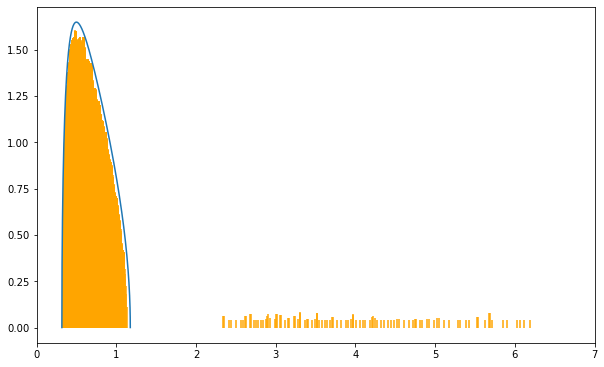

In [192]:
pdf0.plot()
plt.vlines(pdf1.index, 0, pdf1.values, color='orange')
plt.xlim(0,7)

In [193]:
nFacts0

100

In [194]:
eMax0, var0

(1.1756533103447002, 0.6786051870345192)

In [195]:
# denoising by constant residueal eigenvalue
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = cov2corr(corr1)
    return corr1
corr1= denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

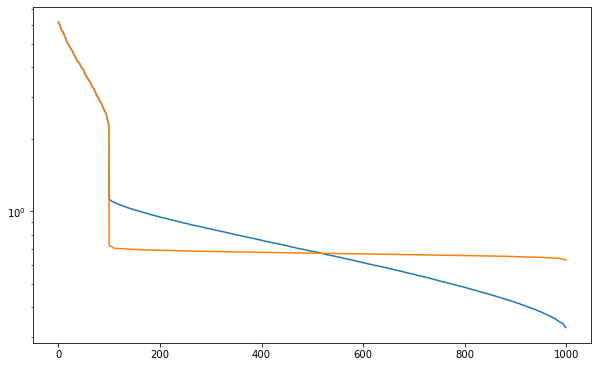

In [197]:
plt.plot(np.diag(eVal0))
plt.plot(np.diag(eVal1))
plt.yscale("log")

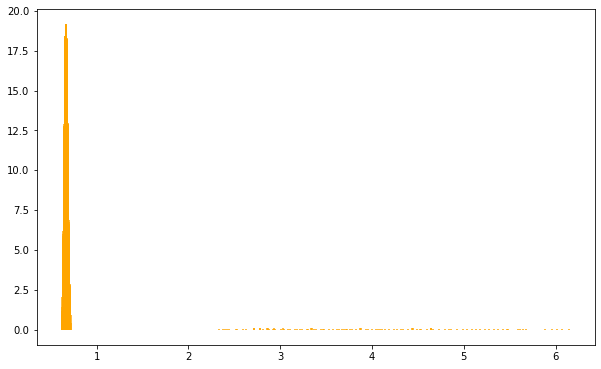

In [186]:
eVal0, eVec0 = getPCA(corr1)
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

pdf0 = mpPDF(var0, q, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)

# pdf0.plot()
plt.vlines(pdf1.index, 0, pdf1.values, color='orange')
# plt.xlim(0,7)

# One protein. phis.

In [482]:

# a = np.load(f"A_B_dic/{pdb}.npy", allow_pickle=True).item()
a = np.load("/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_8/phis/5wie_B.npy")

In [485]:
a.shape

(3000, 1332)

In [495]:
a -= 1e-5

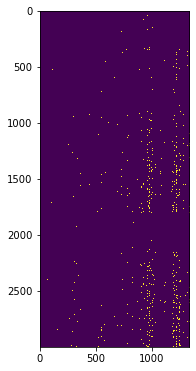

In [497]:
plt.imshow(a!=0)

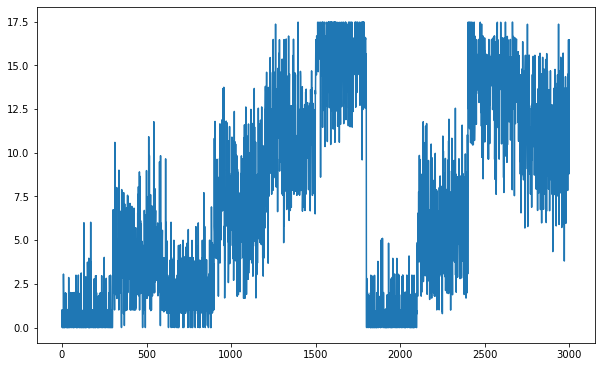

In [502]:
plt.plot(a.sum(axis=1))

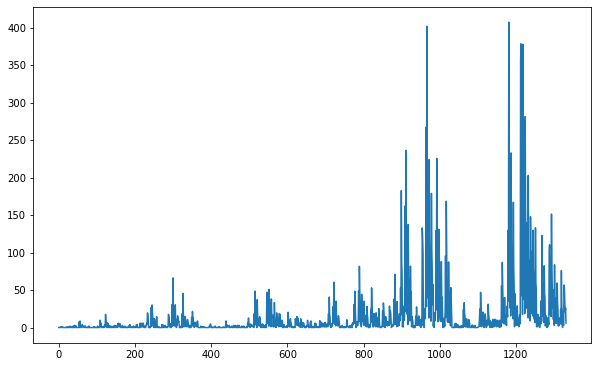

In [505]:
plt.plot(a.sum(axis=0))

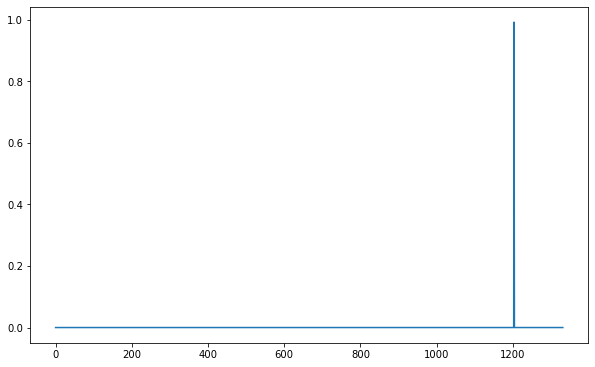

In [501]:
plt.plot(a[3])

In [514]:
corr = np.corrcoef(a, rowvar=0)

/Users/weilu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/weilu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [515]:
corr

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,  1.        ,
         0.02707419, -0.00392677],
       [        nan,         nan,         nan, ...,  0.02707419,
         1.        ,  0.16914799],
       [        nan,         nan,         nan, ..., -0.00392677,
         0.16914799,  1.        ]])

In [517]:
np.cov(a, rowvar=0)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.22700410e-03,  1.93501703e-04, -1.38717191e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.93501703e-04,  8.20313099e-03,  6.85823102e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.38717191e-05,  6.85823102e-04,  2.00406076e-03]])

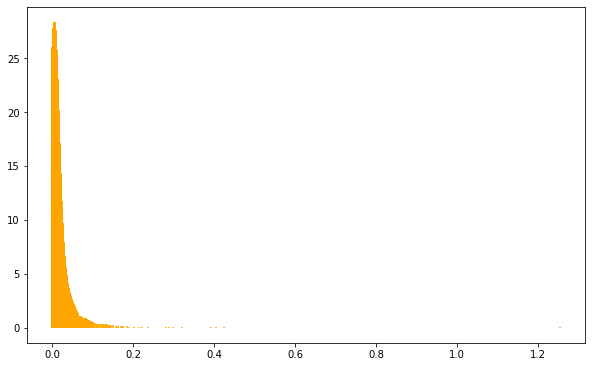

In [494]:
eVal0, eVec0 = getPCA(corr0)
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

pdf0 = mpPDF(var0, q, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)

# pdf0.plot()
plt.vlines(pdf1.index, 0, pdf1.values, color='orange')
# plt.xlim(0,7)

# Read Z score

In [527]:
info = pd.read_csv("/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/complete_info.csv")

In [533]:
a = info.groupby("Protein")["phi"].count().reset_index()

In [537]:
a["count"] = a["phi"]
a = a.drop("phi", axis=1)

In [507]:
data = pd.read_csv("/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_7/z_scores.csv")

In [539]:
a.shape

(1747, 2)

In [543]:
data = data.merge(a, on="Protein")
data["weight"] = data["count"].mean() / data["count"]
data = data.drop("Unnamed: 0", axis=1)

In [548]:
data["count"].mean()

76.58232676414495

In [555]:
data.to_csv("/Users/weilu/Research/server/sep_2020/curated_single_chain_optimization/weight_info.csv")

In [558]:
data = pd.read_csv("/Users/weilu/Research/server/sep_2020/curated_single_chain_optimization/weight_info.csv", index_col=0)
data.query("Protein=='2zzl_A'")["weight"].values[0]

In [565]:
data.shape

(1573, 8)

In [566]:
data["count"].mean()

76.58232676414495

In [546]:
data.corr()

,Unnamed: 0,E_native,E_decoy,E_diff,E_std,Z,count
Unnamed: 0,1.000000,0.012351,0.021893,-0.010862,-0.016912,-0.013447,-0.032814
E_native,0.012351,1.000000,0.474071,-0.996825,-0.863680,-0.796483,-0.652622
E_decoy,0.021893,0.474071,1.000000,-0.402456,-0.362961,-0.260784,-0.224302
E_diff,-0.010862,-0.996825,-0.402456,1.000000,0.865142,0.804517,0.658245
E_std,-0.016912,-0.863680,-0.362961,0.865142,1.000000,0.561488,0.729699
Z,-0.013447,-0.796483,-0.260784,0.804517,0.561488,1.000000,0.531901
count,-0.032814,-0.652622,-0.224302,0.658245,0.729699,0.531901,1.000000


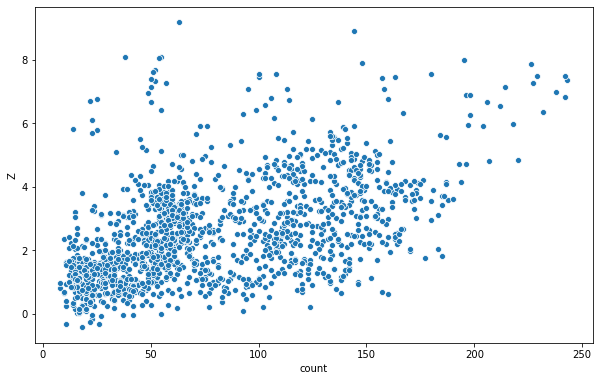

In [545]:
sns.scatterplot("count", "Z", data=data)

In [586]:
data

,phi,res1,res1_2,res2,res2_2,direction,res1_name,res1_2_name,res2_name,res2_2_name,interaction_index
0,0.000078,0,4,141,145,parallel,THR,ILE,GLU,THR,304
1,0.000031,3,7,142,146,parallel,ALA,MET,ALA,LEU,288
2,0.411750,4,8,183,187,parallel,ILE,ALA,SER,VAL,298
3,0.999914,4,8,145,149,parallel,ILE,ALA,THR,THR,243
4,0.820753,4,8,142,146,parallel,ILE,ALA,ALA,LEU,298
...,...,...,...,...,...,...,...,...,...,...,...
148,0.999775,162,166,195,191,anti,PRO,ILE,SER,VAL,1105
149,0.826050,162,166,192,188,anti,PRO,ILE,ILE,PHE,1119
150,0.998130,165,169,191,187,anti,GLY,ILE,VAL,VAL,789
151,0.106775,166,170,188,184,anti,ILE,ILE,PHE,ILE,1214


In [587]:
data = pd.read_csv("/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_mode_7/z_scores.csv")

In [589]:
data = data.merge(a, on="Protein")
data["weight"] = data["count"].mean() / data["count"]
data = data.drop("Unnamed: 0", axis=1)

In [592]:
data.head()

,Protein,E_native,E_decoy,E_diff,E_std,Z,count,weight
0,2zzl_A,-1.409792,-0.129614,1.280178,0.672481,1.903664,52,1.472737
1,4xtl_A,-1.600579,-0.174804,1.425776,0.621685,2.293405,55,1.392406
2,5ejz_A,-0.158237,0.088614,0.246852,0.283522,0.870661,44,1.740507
3,5jae_B,-0.921244,0.200938,1.122182,0.891673,1.258513,135,0.567276
4,1u7g_A,-13.513838,-1.821475,11.692363,2.558445,4.570105,220,0.348101


In [591]:
data.corr()

,E_native,E_decoy,E_diff,E_std,Z,count,weight
E_native,1.000000,0.456533,-0.995043,-0.853712,-0.744396,-0.636925,0.442091
E_decoy,0.456533,1.000000,-0.365790,-0.317781,-0.231652,-0.194814,0.048324
E_diff,-0.995043,-0.365790,1.000000,0.857524,0.752799,0.644494,-0.457058
E_std,-0.853712,-0.317781,0.857524,1.000000,0.455727,0.728955,-0.591068
Z,-0.744396,-0.231652,0.752799,0.455727,1.000000,0.409695,-0.327150
count,-0.636925,-0.194814,0.644494,0.728955,0.409695,1.000000,-0.756868
weight,0.442091,0.048324,-0.457058,-0.591068,-0.327150,-0.756868,1.000000


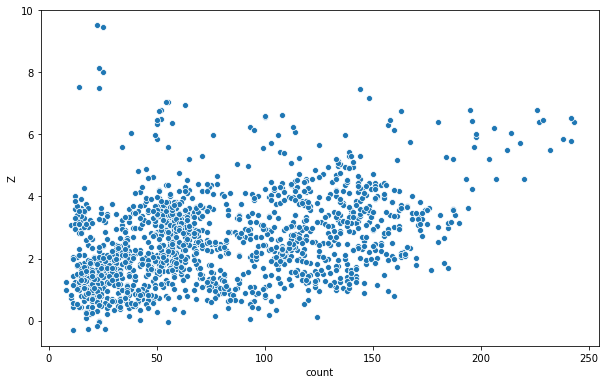

In [590]:
sns.scatterplot("count", "Z", data=data)

In [523]:
data.sort_values("E_native")

,Unnamed: 0,Protein,E_native,E_decoy,E_diff,E_std,Z
1553,1553,6d0j_B,-7.682124,-0.067117,7.615007,0.969002,7.858607
223,223,6lsc_A,-7.459239,-0.096429,7.362810,0.981855,7.498875
214,214,1ots_B,-7.344797,-0.106598,7.238198,0.983961,7.356182
645,645,3nd0_A,-7.264284,-0.114678,7.149606,0.982087,7.280016
1041,1041,1kpl_A,-6.586125,-0.173708,6.412417,1.011027,6.342477
...,...,...,...,...,...,...,...
1254,1254,6oce_A,0.079341,0.080307,0.000965,0.163314,0.005911
1253,1253,5z1f_B,0.108336,0.162565,0.054229,0.259574,0.208917
349,349,6ijz_A,0.109193,0.126410,0.017217,0.228577,0.075324
1079,1079,5y83_A,0.110037,0.101627,-0.008410,0.190701,-0.044099


In [511]:
data.sort_values("Z")

,Unnamed: 0,Protein,E_native,E_decoy,E_diff,E_std,Z
198,198,5v4s_A,0.078096,0.028181,-0.049915,0.118672,-0.420613
179,179,2n02_A,0.036719,-0.018078,-0.054797,0.165165,-0.331772
1466,1466,1ors_C,0.031021,0.013766,-0.017255,0.053855,-0.320400
1200,1200,2h8a_A,0.038914,0.007422,-0.031492,0.119753,-0.262973
124,124,6cjt_A,0.043042,0.025468,-0.017574,0.118615,-0.148156
...,...,...,...,...,...,...,...
21,21,2xow_A,-2.923004,0.055787,2.978791,0.369415,8.063545
19,19,6pj4_A,-3.043153,0.064982,3.108135,0.384835,8.076542
18,18,4huq_S,-2.149296,-0.002089,2.147207,0.265567,8.085358
1399,1399,6qvu_B,-3.790388,-0.000252,3.790137,0.425748,8.902291


In [ ]:
6hiq_A.csv
1ots_B.csv

In [513]:
data.query("Protein=='6hiq_A'")

,Unnamed: 0,Protein,E_native,E_decoy,E_diff,E_std,Z
933,933,6hiq_A,-0.047073,-0.002989,0.044084,0.044809,0.983803


In [526]:
data.query("Protein=='1ots_B'")

,Unnamed: 0,Protein,E_native,E_decoy,E_diff,E_std,Z
214,214,1ots_B,-7.344797,-0.106598,7.238198,0.983961,7.356182


In [525]:
data["E_native"].mean()

-0.8607733765955909

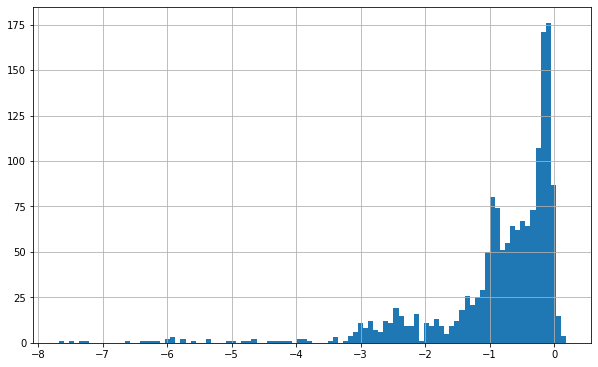

In [524]:
data["E_native"].hist(bins=100)

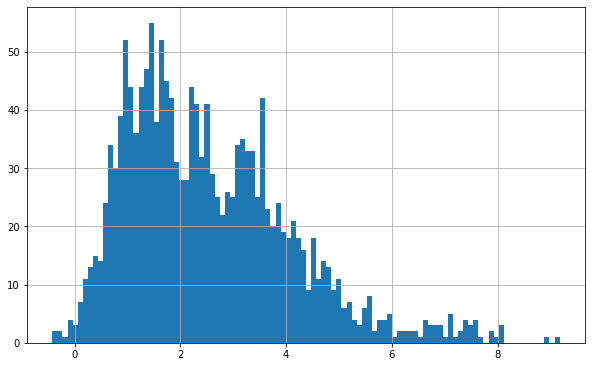

In [510]:
data["Z"].hist(bins=100)

In [405]:
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P


def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors


def get_A_B(pre, n=201, first_half=False, second_half=False,):
    # pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_3/gamma_mode_3"
    A = np.load(f"{pre}/average_A.npy", allow_pickle=True)
    B = np.load(f"{pre}/average_B.npy", allow_pickle=True)
    A_prime = np.load(f"{pre}/average_A_prime.npy", allow_pickle=True)
    half_B = np.load(f"{pre}/average_half_B.npy", allow_pickle=True)
    other_half_B = np.load(f"{pre}/average_other_half_B.npy", allow_pickle=True)
    std_half_B = np.load(f"{pre}/average_std_half_B.npy", allow_pickle=True)
#     A = A[:n]
#     B = B[:n,:n]
#     A_prime = A_prime[:n]
#     half_B = half_B[:n,:n]
#     other_half_B = other_half_B[:n, :n]
#     std_half_B = std_half_B[:n, :n]
    if second_half:
        half_n = int(n/2)
        A = A[half_n:]
        B = B[half_n:,half_n:]
        A_prime = A_prime[half_n:]
        half_B = half_B[half_n:,half_n:]
        other_half_B = other_half_B[half_n:, half_n:]
        std_half_B = std_half_B[half_n:, half_n:]
    A_B_dic = {}
    A_B_dic["A"] = A
    A_B_dic["B"] = B
    A_B_dic["half_B"] = half_B
    A_B_dic["other_half_B"] = other_half_B
    A_B_dic["std_half_B"] = std_half_B
    A_B_dic["A_prime"] = A_prime
    return A_B_dic

def get_gamma(A, B, A_prime, c=-100, cutoff_range=range(100, 210, 10)):
    gamma_cutoff_dic = {}
    for cutoff in list(cutoff_range):
        # cutoff = 400
        lamb, P = np.linalg.eig(B)
        lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
        filtered_lamb = np.copy(lamb)
        cutoff_mode = cutoff
        filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                           cutoff_mode, P)
        B_inv = filtered_B_inv
        lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
        gamma_new = B_inv.dot(A-A_prime*lambda_2)
        gamma_cutoff_dic[cutoff] = gamma_new
    return gamma_cutoff_dic

In [27]:
pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_7/shuffled_half_pdb_list_gamma/"
six_letter_mode7 = get_A_B(pre, n=1332)
# cutoff_range=list(range(300, 800, 100)) + list(range(932, 1332+20, 20))
# gamma_six_letter_mode7 = get_gamma(six_letter_mode7['A'], six_letter_mode7['B'], six_letter_mode7['A_prime'], c=-0, cutoff_range=cutoff_range)


In [407]:
cutoff_range=list(range(300, 800, 100)) + list(range(932, 1332+20, 20)) + [1200]
gamma_six_letter_mode7 = get_gamma(six_letter_mode7['A'], six_letter_mode7['B'], six_letter_mode7['A_prime'], c=-0, cutoff_range=cutoff_range)

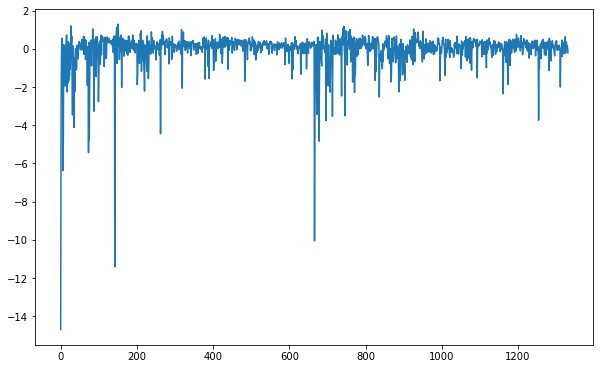

In [408]:
plt.plot(gamma_six_letter_mode7[1200])

In [461]:
# denoising by constant residueal eigenvalue
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    # corr1 = cov2corr(corr1)
    return corr1
eVal0, eVec0 = getPCA(B)
nFacts0 = 1100
corr1= denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

In [462]:
A_prime = six_letter_mode7["A_prime"]
A = six_letter_mode7["A"]
c = 0
filtered_B_inv = np.linalg.inv(corr1)
B_inv = filtered_B_inv
lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
gamma_new = B_inv.dot(A-A_prime*lambda_2)

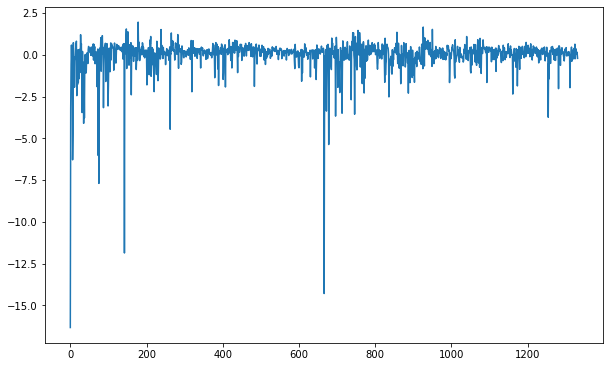

In [463]:
plt.plot(gamma_new)

In [479]:
gamma_max_out =gamma_new.copy() / 3
# gamma_max_out[gamma_max_out< -2] = -2

In [480]:
np.savetxt("/Users/weilu/Research/server/sep_2020//membrane_protein_structure_prediction/six_letter_1100_divide_3.dat", -gamma_max_out)

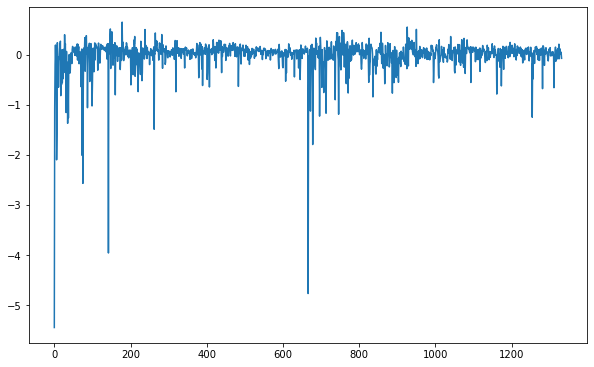

In [481]:
plt.plot(gamma_max_out)

In [476]:
A.dot(gamma_new/3)

2.3074936096157654

In [474]:
A.dot(gamma_max_out)

2.194237238917857

In [518]:
B = six_letter_mode7['B']

In [519]:
B.shape

(1332, 1332)

In [520]:
eVal0, eVec0 = getPCA(B)

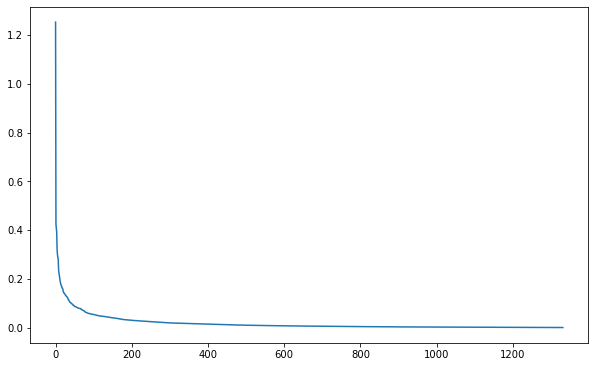

In [522]:
plt.plot(np.diag(eVal0))

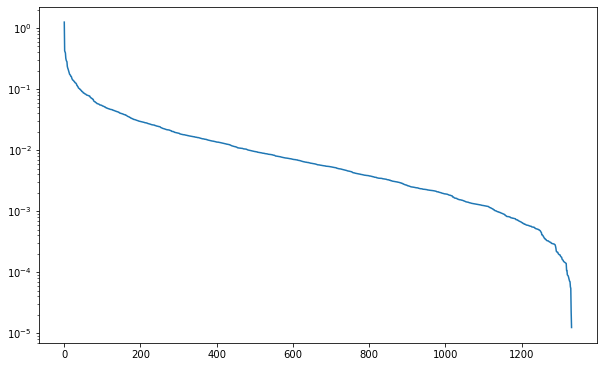

In [521]:
plt.plot(np.diag(eVal0))
plt.yscale("log")

In [456]:
eVal0, eVec0 = getPCA(B)
nFacts0 = 1200
corr1= denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

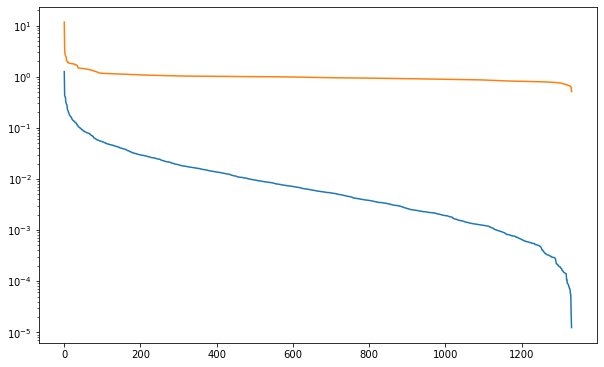

In [457]:
plt.plot(np.diag(eVal0))
plt.plot(np.diag(eVal1))
plt.yscale("log")

In [ ]:
eVal0, eVec0 = getPCA(corr1)
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

pdf0 = mpPDF(var0, q, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)

# pdf0.plot()
plt.vlines(pdf1.index, 0, pdf1.values, color='orange')
# plt.xlim(0,7)

In [396]:
alpha, nCols, nFact, q= .995, 1332, 10, 150000/1332
corr0 = B
eVal0, eVec0 = getPCA(corr0)

      fun: 68498558.22983544
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.77264519e+09])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 3
     njev: 42
   status: 2
  success: False
        x: array([0.00999977])


(0, 1)

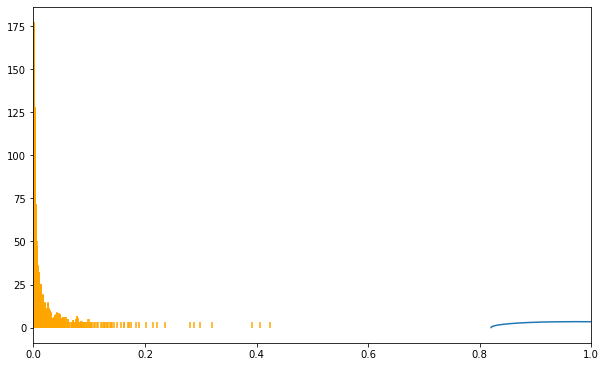

In [399]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=1e-6)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)



pdf0 = mpPDF(var0, q, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=1e-4)

pdf0.plot()
plt.vlines(pdf1.index, 0, pdf1.values, color='orange')
plt.xlim(0,1)
# plt.ylim(0, 500)

In [389]:
var0

0.34062170460307606

In [323]:
def errPDFs(var, eVal, q, bWidth, pts=1000):
    # fit error
    # print(var, eVal, q, bWidth)
    pdf0 = mpPDF(var[0], q, pts)
    # print(pdf0.index.values)
    pdf1=fitKDE(eVal, bWidth, x=pdf0.index.values)
    sse= np.sum((pdf1-pdf0)**2)
    return sse
def findMaxEval(eVal, q, bWidth):
    # find max random eVal by fitting Macenko's dist
    out=minimize(lambda *x:errPDFs(*x), 1e-2, args=(eVal, q, bWidth), bounds=((1E-5,1-1E-5),))
    if out['success']: var=out['x'][0]
    else:
        var=1
        print(out)
    eMax=var*(1+(1./q)**0.5)**2
    return eMax, var

In [342]:
var = 1e-2
pdf0 = mpPDF(var, q, pts=1000)

In [343]:
pdf1=fitKDE(np.diag(eVal0), bWidth=1e-6, x=pdf0.index.values)
sse= np.sum((pdf1-pdf0)**2)

In [344]:
sse

68515392.21978006

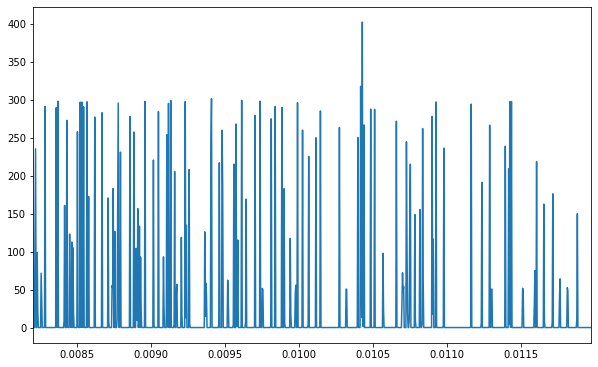

In [345]:
pdf1.plot()

(0, 0.2)

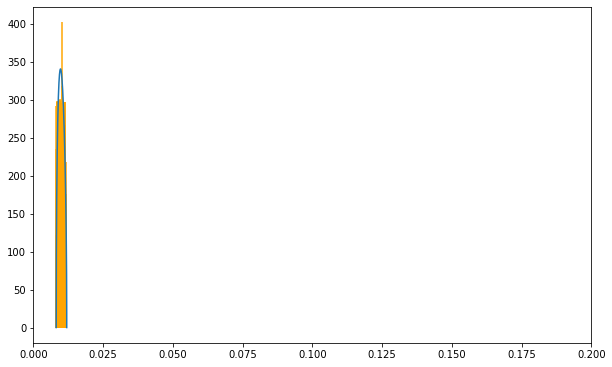

In [348]:
pdf0.plot()
plt.vlines(pdf1.index, 0, pdf1.values, color='orange')
plt.xlim(0,0.2)

In [337]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=1e-6)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)


      fun: 68498558.22983544
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.77264519e+09])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 3
     njev: 42
   status: 2
  success: False
        x: array([0.00999977])


(0, 500)

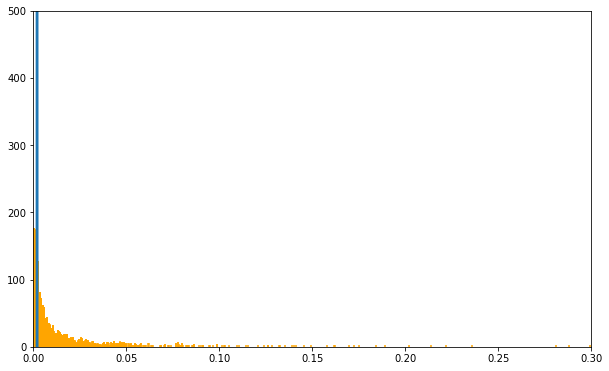

In [371]:
var0 = 2e-3
eMax0=var0*(1+(1./q)**0.5)**2
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
# q = 1.3
pdf0 = mpPDF(var0, q, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=1e-4)

pdf0.plot()
plt.vlines(pdf1.index, 0, pdf1.values, color='orange')
plt.xlim(0,0.3)
plt.ylim(0, 500)

In [372]:
lamb.min()

1.238719621474058e-05

In [373]:
var0

0.002

In [374]:
nFacts0

929

In [76]:
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)

In [74]:
np.diag(eVal0).max()

1.253008071461878

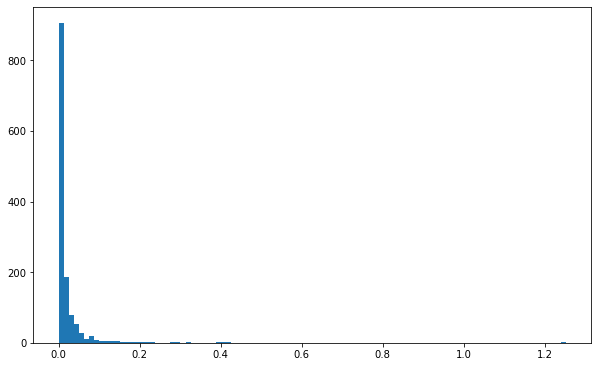

In [81]:
_ = plt.hist(np.diag(eVal0), bins=100)

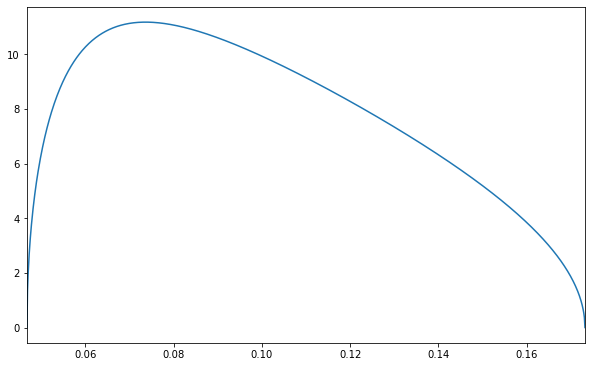

In [93]:
var0 = 0.1
q = 10
pdf0 = mpPDF(var0, q, pts=1000)
pdf0.plot()

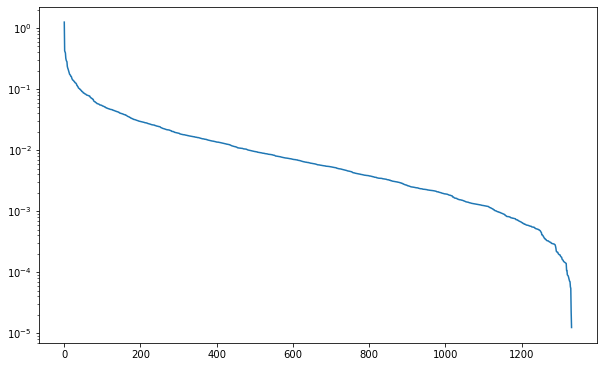

In [77]:
plt.plot(lamb)
plt.yscale("log")

In [83]:
np.diag(eVal0)

array([1.25300807e+00, 4.24309133e-01, 4.05445572e-01, ...,
       5.43917325e-05, 2.22555055e-05, 1.23871962e-05])

In [84]:
lamb

array([1.25300807e+00, 4.24309133e-01, 4.05445572e-01, ...,
       5.43917325e-05, 2.22555055e-05, 1.23871962e-05])

In [86]:
abs(np.diag(eVal0) - lamb).max()

4.690692279041286e-15

In [569]:
def getSeqFromFasta(fastaFile):
    # "/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/setup/1pv6/1pv6.fasta"
    with open(fastaFile) as f:
        a = f.readlines()
    seq = ""
    for line in a:
        if line[0] == ">":
            continue
        seq += line.strip()
    return seq


In [571]:
seq = getSeqFromFasta("/Users/weilu/Research/server/sep_2020/target_protein_information/1kpl.fasta")

In [580]:
data = pd.read_csv("/Users/weilu/Research/server/sep_2020/target_protein_information/info_folder/1kpl-cleaned.csv", index_col=0)

In [585]:
data.query("interaction_index==0")

,phi,res1,res1_2,res2,res2_2,direction,res1_name,res1_2_name,res2_name,res2_2_name,interaction_index
35,0.003272,12,16,150,154,parallel,GLY,GLY,GLY,GLY,0


In [582]:
gamma = -np.loadtxt("/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/six_letter_limit_max.dat")

In [583]:
energy = 0
for i, line in data.iterrows():
    phi = line["phi"]
    index = line["interaction_index"]
    energy += gamma[index] * phi
energy

-22.574339508462927